In [1]:
import os
os.chdir(r"D:\PhD Classes (Big_files)\Neural Networks\Neural Networks\Project\ResNet50\Validation")

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import rasterio
import sys
import PIL # pillow - image processing

In [3]:
img_dir = r"image_2nd_dataset\24813_sat.jpg"
model_dir = r"D:\PhD Classes (Big_files)\Neural Networks\Neural Networks\Project\Tutorial_1\ResNet50_eurosat.h5"

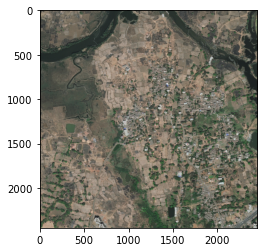

In [48]:
img = PIL.Image.open(img_dir, 'r')
img_array = np.asarray(img)/255.0
plt.imshow(img_array[:,:,:])
plt.imsave(r'Final_plots\complete.png', img_array)

In [5]:
img_array.shape

(2448, 2448, 3)

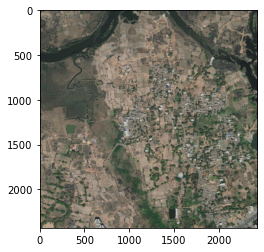

In [34]:
img_clipped = img_array[0:2432,0:2432,:]
plt.imshow(img_clipped[:,:,:])

In [35]:
img_clipped.shape[0]

2432

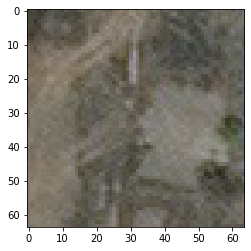

In [36]:
little_img = img_clipped[100:100+64, 100:100+64,:]
plt.imshow(little_img[:,:,:])

In [31]:
little_img[:,:,2]

array([[0.28235294, 0.21568627, 0.20392157, ..., 0.35294118, 0.35294118,
        0.30196078],
       [0.2       , 0.21176471, 0.21960784, ..., 0.34117647, 0.32156863,
        0.22745098],
       [0.23137255, 0.21176471, 0.24313725, ..., 0.27843137, 0.2627451 ,
        0.2745098 ],
       ...,
       [0.21960784, 0.25098039, 0.23137255, ..., 0.33333333, 0.34117647,
        0.29803922],
       [0.21960784, 0.22745098, 0.24705882, ..., 0.3372549 , 0.30588235,
        0.29803922],
       [0.41176471, 0.41568627, 0.38039216, ..., 0.30980392, 0.34509804,
        0.34117647]])

In [32]:
a = little_img.reshape(1, 64, 64, 3).astype('float16')
a[0,:,:,2]

array([[0.2825, 0.2157, 0.204 , ..., 0.353 , 0.353 , 0.302 ],
       [0.2   , 0.2118, 0.2196, ..., 0.341 , 0.3215, 0.2274],
       [0.2313, 0.2118, 0.2432, ..., 0.2783, 0.2627, 0.2744],
       ...,
       [0.2196, 0.251 , 0.2313, ..., 0.3333, 0.341 , 0.298 ],
       [0.2196, 0.2274, 0.2471, ..., 0.3372, 0.306 , 0.298 ],
       [0.4119, 0.4158, 0.3804, ..., 0.3098, 0.3452, 0.341 ]],
      dtype=float16)

# Predicting  each 64x64 pixel

In [33]:
# Load the model one time
resnet50_model = tf.keras.models.load_model(model_dir)

In [28]:
steps = 64 # pixels
start = datetime.now()
prediction_file = open("predictions.txt", "w")
for i in range(0,img_clipped.shape[0],steps):

    predictions = []
    print("Processing Row: %s @ %s" % (i, datetime.now()))
    for j in range(0,img_clipped.shape[1],steps):
               
        # Create tile
        little_img = img_clipped[i:i+64, j:j+64,:]

        # Predict
        predicted = resnet50_model.predict(little_img.reshape(1, 64, 64, 3).astype('float16'))
        predictions.append(str(predicted.argmax()))

        # Optimization        
        del little_img, predicted
        K.clear_session()
    
    # Flush the predictions of row to file
    prediction_file.write(("%s," % i) + ",".join(predictions) + "\n")
    prediction_file.flush()
    sys.stdout.flush()

    # Optimization
    if i % 10 == 0:
        del resnet50_model
        K.clear_session()
        resnet50_model = tf.keras.models.load_model(model_dir)

end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))
prediction_file.close()

Processing Row: 0 @ 2021-04-29 13:22:34.944445
Processing Row: 64 @ 2021-04-29 13:22:46.648689
Processing Row: 128 @ 2021-04-29 13:22:48.706705
Processing Row: 192 @ 2021-04-29 13:22:50.079877
Processing Row: 256 @ 2021-04-29 13:22:51.465966
Processing Row: 320 @ 2021-04-29 13:22:52.838132
Processing Row: 384 @ 2021-04-29 13:23:03.366571
Processing Row: 448 @ 2021-04-29 13:23:05.475461
Processing Row: 512 @ 2021-04-29 13:23:06.916905
Processing Row: 576 @ 2021-04-29 13:23:08.352078
Processing Row: 640 @ 2021-04-29 13:23:10.043180
Processing Row: 704 @ 2021-04-29 13:23:20.928928
Processing Row: 768 @ 2021-04-29 13:23:23.171715
Processing Row: 832 @ 2021-04-29 13:23:24.555742
Processing Row: 896 @ 2021-04-29 13:23:26.092120
Processing Row: 960 @ 2021-04-29 13:23:27.596314
Processing Row: 1024 @ 2021-04-29 13:23:38.214603
Processing Row: 1088 @ 2021-04-29 13:23:40.370964
Processing Row: 1152 @ 2021-04-29 13:23:42.036346
Processing Row: 1216 @ 2021-04-29 13:23:43.483535
Processing Row: 128

# Plotting the predicted labels

In [29]:
prediction = "predictions.txt"
classes = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 
           4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 
           7: 'Residential', 8: 'River', 9: 'SeaLake'}


# Read the Predictions file
rows = {}
with open(prediction) as data:
    for row in data:
        values = [int(i) for i in row.split(",")]
        rows[values[0]] = values[1:]
predicted_img = np.array([*rows.values()])

In [30]:
predicted_img

array([[6, 6, 2, ..., 6, 2, 2],
       [2, 2, 2, ..., 6, 2, 1],
       [2, 6, 2, ..., 6, 2, 1],
       ...,
       [2, 2, 6, ..., 6, 5, 4],
       [6, 2, 2, ..., 6, 6, 2],
       [2, 6, 2, ..., 4, 2, 4]])

In [31]:
predicted_img.shape

(38, 38)

C:\Users\said_\Anaconda3\envs\Tensorflow_Deep_Learning\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


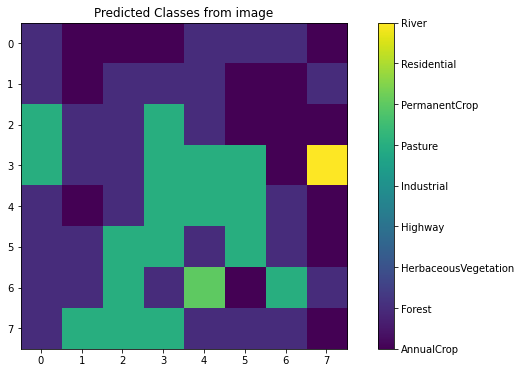

AttributeError: 'tuple' object has no attribute 'shape'

In [49]:
# Plotting
fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# Predicted plot
img2 = ax2.imshow(predicted_img)
cbar = plt.colorbar(img2, fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(classes.values())
ax2.set_title("Predicted Classes from image")

# Display the plot
plt.show()

In [33]:
import matplotlib
from matplotlib.colors import ListedColormap


def plot_label(mask, labels, col_dict):
    # Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
    # col_dict={1:"blue",
    #           2:"red",
    #           3:"orange",
    #           4:"green",
    #           5:"yellow",
    #           6:"purple",
    #           7:"grey"}
    
    # We create a colormar from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
    
    # Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
    # labels = np.array(['urban_land','agriculture_land','rangeland','forest_land','water','barren_land','unknown'])
    len_lab = len(labels)
    
    
    # prepare normalizer
    ## Prepare bins for the normalizer
    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
    #print(norm_bins)
    ## Make normalizer and formatter
    norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])
    
    # Plot our figure
    fig,ax = plt.subplots()
    im = ax.imshow(mask, cmap=cm, norm=norm)
    
    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2
    cb = fig.colorbar(im, format=fmt, ticks=tickz)
    


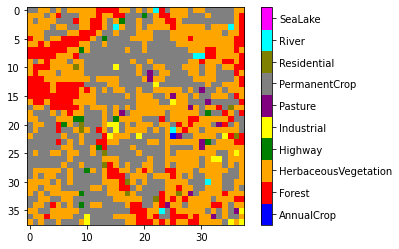

In [34]:
labels = np.array(['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 
           'Industrial', 'Pasture', 'PermanentCrop', 
           'Residential','River','SeaLake'])
col_dict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 
           4: 'yellow', 5: 'purple', 6: 'grey', 
           7: 'olive', 8: 'cyan', 9: 'magenta'}
plot_label(predicted_img, labels,col_dict)

# Improving results

In [9]:
img_clipped_2 = img_array[500:1000,1900:2400,:]

In [10]:
# Pad the image
test_img_pad = np.pad(img_clipped_2, ((32, 32), (32, 32),(0, 0)), mode="empty")
test_img_pad.shape

(564, 564, 3)

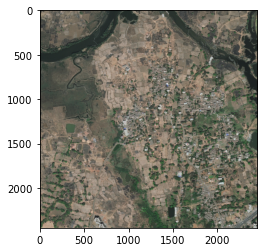

In [11]:
plt.imshow(img_array[:,:,:])

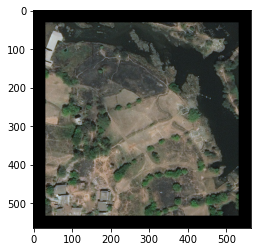

In [50]:
plt.imshow(test_img_pad)
plt.imsave(r'Final_plots\crop_image.png', test_img_pad)

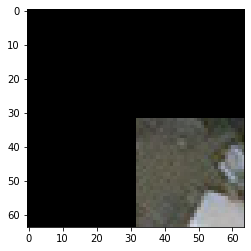

In [13]:
plt.imshow(test_img_pad[0:64,0:64,:])

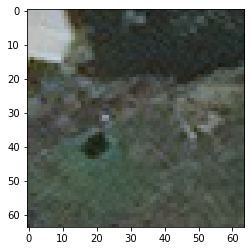

In [14]:
plt.imshow(test_img_pad[64:64+64,64:64+64,:])

In [15]:
# Load the model one time
resnet50_model = tf.keras.models.load_model(model_dir)

In [16]:
start = datetime.now()
ROWS = 500
COLS = 500
prediction_file = open("predictions_pad.txt", "w")
for i in range(ROWS):

    predictions = []
    print("Processing Row: %s @ %s" % (i, datetime.now()))
    for j in range(COLS):
               
        # Create tile
        tile = ((i, i+64), (j, j+64))
        tile_img = test_img_pad[i:i+64, j:j+64,:]

        # Predict
        predicted = resnet50_model.predict(tile_img.reshape(1, 64, 64, 3).astype('float16'))
        predictions.append(str(predicted.argmax()))

        # Optimization        
        del tile_img, predicted
        K.clear_session()
    
    # Flush the predictions of row to file
    prediction_file.write(("%s," % i) + ",".join(predictions) + "\n")
    prediction_file.flush()
    sys.stdout.flush()

    # Optimization
    if i % 10 == 0:
        del resnet50_model
        K.clear_session()
        resnet50_model = tf.keras.models.load_model(model_dir)

end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))
prediction_file.close()

Processing Row: 0 @ 2021-04-29 13:37:21.836160
Processing Row: 1 @ 2021-04-29 13:37:52.771594
Processing Row: 2 @ 2021-04-29 13:38:13.010510
Processing Row: 3 @ 2021-04-29 13:38:32.938068
Processing Row: 4 @ 2021-04-29 13:38:52.413571
Processing Row: 5 @ 2021-04-29 13:39:12.082507
Processing Row: 6 @ 2021-04-29 13:39:32.275950
Processing Row: 7 @ 2021-04-29 13:39:51.747634
Processing Row: 8 @ 2021-04-29 13:40:11.887193
Processing Row: 9 @ 2021-04-29 13:40:31.529518
Processing Row: 10 @ 2021-04-29 13:40:51.158070
Processing Row: 11 @ 2021-04-29 13:41:20.036061
Processing Row: 12 @ 2021-04-29 13:41:40.141621
Processing Row: 13 @ 2021-04-29 13:41:59.849958
Processing Row: 14 @ 2021-04-29 13:42:19.479805
Processing Row: 15 @ 2021-04-29 13:42:39.140540
Processing Row: 16 @ 2021-04-29 13:42:58.778069
Processing Row: 17 @ 2021-04-29 13:43:17.546605
Processing Row: 18 @ 2021-04-29 13:43:36.369371
Processing Row: 19 @ 2021-04-29 13:43:54.838913
Processing Row: 20 @ 2021-04-29 13:44:13.371564
Pr

# Plotting the predicted labels

In [17]:
prediction = "predictions_pad.txt"
classes = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 
           4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 
           7: 'Residential', 8: 'River', 9: 'SeaLake'}


# Read the Predictions file
rows = {}
with open(prediction) as data:
    for row in data:
        values = [int(i) for i in row.split(",")]
        rows[values[0]] = values[1:]
predicted_img = np.array([*rows.values()])

In [18]:
predicted_img

array([[9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9],
       ...,
       [9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9]])

In [19]:
predicted_img.shape

(500, 500)

C:\Users\said_\Anaconda3\envs\Tensorflow_Deep_Learning\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


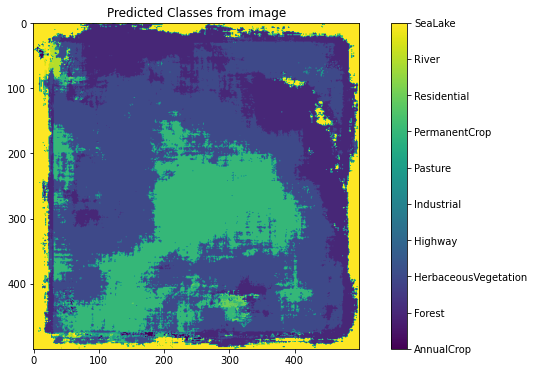

In [20]:
# Plotting
fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# Predicted plot
img2 = ax2.imshow(predicted_img)
cbar = plt.colorbar(img2, fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(classes.values())
ax2.set_title("Predicted Classes from image")

# Display the plot
plt.show()

In [21]:
import matplotlib
from matplotlib.colors import ListedColormap


def plot_label(mask, labels, col_dict):
    # Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
    # col_dict={1:"blue",
    #           2:"red",
    #           3:"orange",
    #           4:"green",
    #           5:"yellow",
    #           6:"purple",
    #           7:"grey"}
    
    # We create a colormar from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
    
    # Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
    # labels = np.array(['urban_land','agriculture_land','rangeland','forest_land','water','barren_land','unknown'])
    len_lab = len(labels)
    
    
    # prepare normalizer
    ## Prepare bins for the normalizer
    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
    #print(norm_bins)
    ## Make normalizer and formatter
    norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])
    
    # Plot our figure
    fig,ax = plt.subplots()
    im = ax.imshow(mask, cmap=cm, norm=norm)
    
    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2
    cb = fig.colorbar(im, format=fmt, ticks=tickz)
    


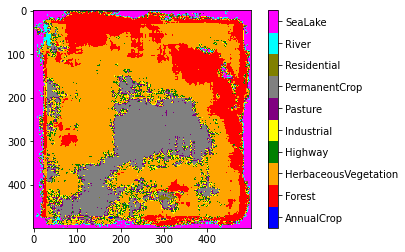

In [22]:
labels = np.array(['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 
           'Industrial', 'Pasture', 'PermanentCrop', 
           'Residential','River','SeaLake'])
col_dict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 
           4: 'yellow', 5: 'purple', 6: 'grey', 
           7: 'olive', 8: 'cyan', 9: 'magenta'}
plot_label(predicted_img, labels,col_dict)

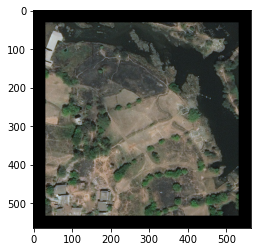

In [23]:
plt.imshow(test_img_pad)

# Predicting  each 64x64 pixel same size as before

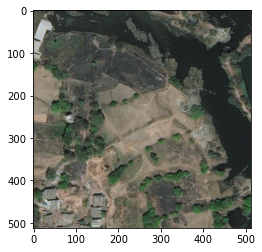

In [37]:
img_clipped3 = img_array[500:1012,1900:2412,:]
plt.imshow(img_clipped3[:,:,:])

In [38]:
# Load the model one time
resnet50_model = tf.keras.models.load_model(model_dir)

In [39]:
steps = 64 # pixels
start = datetime.now()
prediction_file = open("predictions_512.txt", "w")
for i in range(0,img_clipped3.shape[0],steps):

    predictions = []
    print("Processing Row: %s @ %s" % (i, datetime.now()))
    for j in range(0,img_clipped3.shape[1],steps):
               
        # Create tile
        little_img = img_clipped3[i:i+64, j:j+64,:]

        # Predict
        predicted = resnet50_model.predict(little_img.reshape(1, 64, 64, 3).astype('float16'))
        predictions.append(str(predicted.argmax()))

        # Optimization        
        del little_img, predicted
        K.clear_session()
    
    # Flush the predictions of row to file
    prediction_file.write(("%s," % i) + ",".join(predictions) + "\n")
    prediction_file.flush()
    sys.stdout.flush()

    # Optimization
    if i % 10 == 0:
        del resnet50_model
        K.clear_session()
        resnet50_model = tf.keras.models.load_model(model_dir)

end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))
prediction_file.close()

Processing Row: 0 @ 2021-04-29 16:42:29.496129
Processing Row: 64 @ 2021-04-29 16:42:43.922393
Processing Row: 128 @ 2021-04-29 16:42:45.277193
Processing Row: 192 @ 2021-04-29 16:42:45.714233
Processing Row: 256 @ 2021-04-29 16:42:46.131012
Processing Row: 320 @ 2021-04-29 16:42:46.530703
Processing Row: 384 @ 2021-04-29 16:42:59.164689
Processing Row: 448 @ 2021-04-29 16:43:00.578775

Time Taken for testing: 0:00:31.484149


# Plotting the predicted labels

In [40]:
prediction = "predictions_512.txt"
classes = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 
           4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 
           7: 'Residential', 8: 'River', 9: 'SeaLake'}


# Read the Predictions file
rows = {}
with open(prediction) as data:
    for row in data:
        values = [int(i) for i in row.split(",")]
        rows[values[0]] = values[1:]
predicted_img = np.array([*rows.values()])

In [41]:
predicted_img

array([[2, 1, 1, 1, 2, 2, 2, 1],
       [2, 1, 2, 2, 2, 1, 1, 2],
       [6, 2, 2, 6, 2, 1, 1, 1],
       [6, 2, 2, 6, 6, 6, 1, 9],
       [2, 1, 2, 6, 6, 6, 2, 1],
       [2, 2, 6, 6, 2, 6, 2, 1],
       [2, 2, 6, 2, 7, 1, 6, 2],
       [2, 6, 6, 6, 2, 2, 2, 1]])

In [42]:
predicted_img.shape

(8, 8)

C:\Users\said_\Anaconda3\envs\Tensorflow_Deep_Learning\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


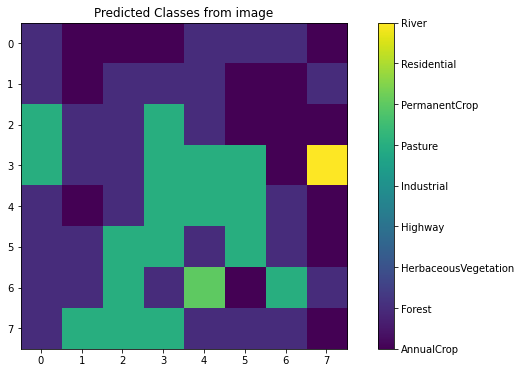

In [43]:
# Plotting
fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# Predicted plot
img2 = ax2.imshow(predicted_img)
cbar = plt.colorbar(img2, fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(classes.values())
ax2.set_title("Predicted Classes from image")

# Display the plot
plt.show()

In [44]:
import matplotlib
from matplotlib.colors import ListedColormap


def plot_label(mask, labels, col_dict):
    # Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
    # col_dict={1:"blue",
    #           2:"red",
    #           3:"orange",
    #           4:"green",
    #           5:"yellow",
    #           6:"purple",
    #           7:"grey"}
    
    # We create a colormar from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
    
    # Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
    # labels = np.array(['urban_land','agriculture_land','rangeland','forest_land','water','barren_land','unknown'])
    len_lab = len(labels)
    
    
    # prepare normalizer
    ## Prepare bins for the normalizer
    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
    #print(norm_bins)
    ## Make normalizer and formatter
    norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])
    
    # Plot our figure
    fig,ax = plt.subplots()
    im = ax.imshow(mask, cmap=cm, norm=norm)
    
    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2
    cb = fig.colorbar(im, format=fmt, ticks=tickz)
    


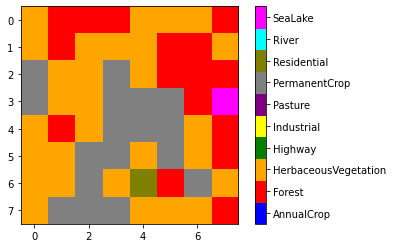

In [45]:
labels = np.array(['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 
           'Industrial', 'Pasture', 'PermanentCrop', 
           'Residential','River','SeaLake'])
col_dict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 
           4: 'yellow', 5: 'purple', 6: 'grey', 
           7: 'olive', 8: 'cyan', 9: 'magenta'}
plot_label(predicted_img, labels,col_dict)